In [4]:
import numpy as np
import cv2
import os
from utils import *
from math import sqrt, atan2, exp
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
## load the data
path = os.getcwd() + '/../data/'  
images_np = images_np_load(path, plot=False)

已加载: 1.jpg, 尺寸: (3, 241, 321)
已加载: 2.jpg, 尺寸: (3, 223, 296)
已加载: 3.jpg, 尺寸: (3, 204, 275)
已加载: 4.jpg, 尺寸: (3, 305, 305)
已加载: 5.jpg, 尺寸: (3, 250, 286)


In [ ]:
def get_region(c, size, image):
    if len(image.shape) == 3:
        return image[c[0] - size // 2: c[0] + size // 2, c[1] - size// 2: c[1] + size // 2, :]
    else:
        return image[c[0] - size // 2: c[0] + size // 2, c[1] - size// 2: c[1] + size // 2]

def simliarity(image, x1, x2, patchsize, alpha=0.1):
    region1 = get_region(x1, patchsize, image)
    region2 = get_region(x2, patchsize, image)
    #print(x1, x2, region1.shape, region2.shape, image.shape)
    sim = np.exp(-alpha * np.sum((region1 - region2) ** 2))
    return sim

def self_simliarity(image, regionsize=41, patchsize=5):
    H, W = image.shape[0], image.shape[1]
    search_r = regionsize // 2
    region_r = patchsize // 2
    similiarity_map = [[0 for _ in range(W - regionsize + 1)] for _ in range(H - regionsize + 1)]
    for i in range(H - regionsize + 1):
        for j in range(W - regionsize + 1):
            xc = [i + regionsize // 2, j + regionsize // 2]
            sim = np.zeros((regionsize - patchsize + 1, regionsize - patchsize + 1)).astype(np.float32)
            for m in range(regionsize - patchsize + 1):
                for n in range(regionsize - patchsize + 1):
                    y = [i + m + patchsize // 2, j + n + patchsize // 2]
                    sim[m][n] = simliarity(image, xc, y, patchsize)
            print(sim.shape)
            similiarity_map[i][j] = sim
    return np.array(similiarity_map)

print(self_simliarity(np.transpose(images_np[0], [1, 2, 0])).shape)

(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(37, 37)
(

KeyboardInterrupt: 

In [56]:
import numpy as np

def get_padded_image(image, pad):
    """给图像周围补零，方便边界处理"""
    if image.ndim == 3:
        return np.pad(image, ((pad,pad),(pad,pad),(0,0)), mode='constant')
    else:
        return np.pad(image, ((pad,pad),(pad,pad)), mode='constant')

def log_polar_offsets(regionsize, num_r=20, num_theta=36):
    """生成 log-polar 相对坐标偏移表"""
    r_max = regionsize / 2
    r = np.logspace(0, np.log10(r_max), num_r) - 1  # log radius
    theta = np.linspace(0, 2*np.pi, num_theta, endpoint=False)
    rr, tt = np.meshgrid(r, theta, indexing='ij')
    dy = (rr * np.sin(tt)).astype(int)
    dx = (rr * np.cos(tt)).astype(int)
    offsets = np.stack([dy, dx], axis=-1)  # shape (num_r,num_theta,2)
    return offsets

def self_similarity_logpolar_fast(image, regionsize=41, patchsize=5, alpha=0.1, num_r=4, num_theta=20):
    H, W = image.shape[:2]
    pad = regionsize // 2 + patchsize // 2
    padded = get_padded_image(image, pad)
    out_H = H - regionsize + 1
    out_W = W - regionsize + 1

    offsets = log_polar_offsets(regionsize, num_r, num_theta)
    sim_map = np.zeros((out_H, out_W, num_r, num_theta), dtype=np.float32)

    # 枚举所有中心点
    y_coords = np.arange(out_H) + pad
    x_coords = np.arange(out_W) + pad

    for i, y in enumerate(y_coords):
        for j, x in enumerate(x_coords):
            # 中心 patch
            yc, xc = y, x
            cp = padded[yc - patchsize//2 : yc + patchsize//2 + 1,
                        xc - patchsize//2 : xc + patchsize//2 + 1]

            # log-polar 索引
            ys = yc + offsets[:,:,0]
            xs = xc + offsets[:,:,1]

            # 越界 mask
            ys = np.clip(ys, 0, padded.shape[0]-patchsize)
            xs = np.clip(xs, 0, padded.shape[1]-patchsize)

            # 批量获取 patch
            for r_idx in range(num_r):
                for t_idx in range(num_theta):
                    y_patch = ys[r_idx, t_idx]
                    x_patch = xs[r_idx, t_idx]
                    patch = padded[y_patch : y_patch+patchsize,
                                   x_patch : x_patch+patchsize]
                    sim_map[i,j,r_idx,t_idx] = np.exp(-alpha * np.sum((cp - patch)**2))
    return sim_map

# 示例调用
image = np.transpose(images_np[0], [1,2,0])
sim_map_fast = self_similarity_logpolar_fast(image)
print(sim_map_fast.shape)  # (H', W', num_r, num_theta)


(201, 281, 4, 20)


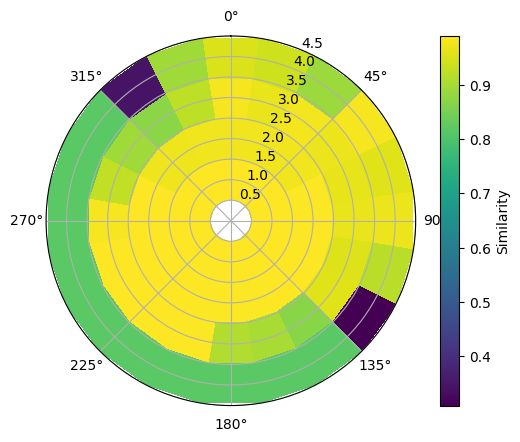

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_logpolar_feature(sim_feature):
    """
    sim_feature: shape (num_r, num_theta)
    """
    num_r, num_theta = sim_feature.shape
    
    # 扩展半径数组和角度数组
    r = np.arange(1, num_r+1)  # 可以换成实际 log 半径
    theta = np.linspace(0, 2*np.pi, num_theta, endpoint=False)
    
    # meshgrid，用于极坐标绘图
    Theta, R = np.meshgrid(theta, r)
    
    # 创建极坐标图
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    
    # 绘制扇形图
    c = ax.pcolormesh(Theta, R, sim_feature, shading='auto', cmap='viridis')
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    fig.colorbar(c, ax=ax, label='Similarity')
    plt.show()


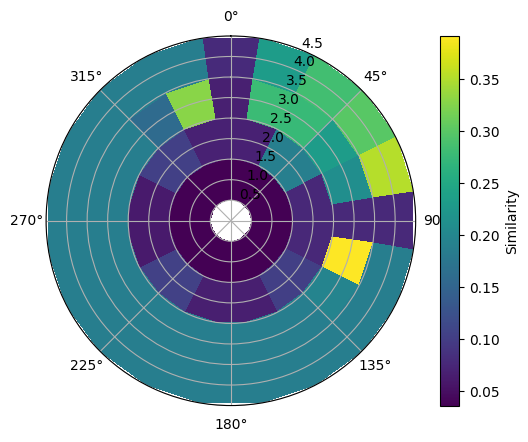

In [58]:

visualize_logpolar_feature(sim_map_fast[0][0])
